In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Allow import of custom modules from the "src" folder
import sys
sys.path.insert(0, 'src/') # solve annoying path issues (ModuleNotFoundError)

# Standard packages for data analysis 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
sns.set(style='whitegrid')

# Web scraping
from scrape_wiki import PageviewsClient
from update_keywords import read_keywords

# Other
from functools import reduce

In [3]:
# Path management
data_path = "data/"

# **TODOs** 

* Modify titles numbers (I, II, III) once it won't change

---

# Keywords selection



## GDPR-related keywords

Selected GDPR-related keywords was mainly done by manual selection of relevant articles, we simply wrote them in a text file and we load them in the cells below:

In [4]:
# Setup path and settings
keywords_GDPR = data_path + 'GDPR_{}.txt'
language = 'de'

In [5]:
# Load list of keywords with our custom function
keywords = read_keywords(keywords_GDPR.format(language))
sorted(keywords)

['Anonymisierung und Pseudonymisierung',
 'AnonymitÃ¤t',
 'Automatische Identifikation und Datenerfassung',
 'Big Data',
 'Business Intelligence',
 'Cyber-Terrorismus',
 'Daten',
 'Datenanalyse',
 'Datenmanagement',
 'Datenschutz',
 'Datenschutz-Grundverordnung',
 'Datenschutz-Grundverordnung',
 'DatenschutzerklÃ¤rung',
 'Datenschutzrecht',
 'Datenvernichtung',
 'Digitale Rechte',
 'Digitale Rechteverwaltung',
 'Erhebung (Empirie)',
 'EuropÃ¤ische Kommission',
 'GlÃ¤serner Mensch (Datenschutz)',
 'HTTP-Cookie',
 'Individualrecht',
 'Informationsintegration',
 'Informationsmanagement',
 'Informationssicherheit',
 'Internet Governance',
 'Internet Privacy Act',
 'Langzeitarchivierung',
 'Online-Durchsuchung',
 'Personenbezogene Daten',
 'PersÃ¶nliche Identifikationsnummer',
 'PrivatsphÃ¤re',
 'Rechtsinformatik',
 'Richtlinie 95/46/EG (Datenschutzrichtlinie)',
 'Transparenz (Politik)',
 'Verordnung (EU)',
 'Verschwiegenheitspflicht',
 'Vorratsdatenspeicherung',
 'Zensur im Internet']

## Popular articles

One can find the selection of popular Wikipedia articles under the Web Scraping section.

---

# Web Scraping

In this section, we reproduce the steps performed to obtain the dataset we will work on. This is mainly a summary of what is shown in the [Scraping](Scraping.ipynb) notebook. 

## Setup 

According to the [Wikipedia REST API rules](https://wikimedia.org/api/rest_v1/), we must specify a contact address as the `User-Agent` for queries to the database.

In [6]:
# Set contact address
contact = 'matthias.zeller@epfl.ch'

# Instanciate query function
p = PageviewsClient(contact)

In [7]:
# Parameters to request article views
params = {
    'agent': 'user',
    'start': '20150401', # 1st April 2015
    'end':   '20190531'  # 31th May 2019
}

In [8]:
from concurrent.futures import ThreadPoolExecutor

# Helper functions
def request_top(dates, domain=language, limit=500):
    """
    Wraps the function PageviewsClient.top_articles.
    
    Parameters 
    ----------
    dates: list 
           List of dictionnaries with keys 'year', 'month', 'day'
    domain: str
            Specifies the Wikipedia project (en, de, fr, ...)
    limit: int
           Number of top articles to fetch for a given date
    
    Returns
    -------
    df : pandas.DataFrame
        Dataframe with columns year, month, day, views, article, rank
    """
    def fetch_date(d):
        try:
            df = p.top_articles(domain, **d, limit=limit)
        except Exception:
            # Happens if data not available
            return pd.DataFrame()
        
        df = pd.DataFrame(df)
        df['year'] = d['year']
        df['month'] = d['month']
        df['day'] = d['day']
        return df
    
    domain = domain + '.wikipedia'
    
    # Fetch with parallel requests
    with ThreadPoolExecutor(10) as executor:
        res = list(executor.map(fetch_date, dates))
    
    # Format results in a DataFrame
    res = pd.concat(res, ignore_index=True)
    # Replace None -> np.nan
    res = res.applymap(lambda elem: np.nan if elem is None else elem)
    
    res['language'] = domain.split('.')[0]
    
    return res


def request(articles, domain=language, **kwargs):
    """
    Wraps the function PageviewsClient.article_views
    
    Parameters
    ----------
    articles : list
              List of Wikipedia article names
    domain : str
            Wikipedia project (de, en, es, fr...)
    kwargs
            Additionnal arguments that override `params` and passed to article_views()
            
    Returns
    -------
    df : pandas.DataFrame
         Dataset with columns being articles and index are dates
    """
    wrapped_kwargs = params.copy()
    wrapped_kwargs.update(kwargs)
    domain = domain + '.wikipedia'
    
    # Fetch
    res = p.article_views(articles=articles, project=domain, **wrapped_kwargs)
    
    # Format results in a DataFrame
    res = pd.DataFrame(res).T
    # Replace None -> np.nan
    res = res.applymap(lambda elem: np.nan if elem is None else elem)
    # Sort by dates
    res.sort_index(inplace=True)
    
    return res

## Popular articles selection

We will use (a modified version of) the `top_articles` function from the [python-mwviews](https://github.com/mediawiki-utilities/python-mwviews/blob/master/mwviews/api/pageviews.py) package to fetch the most popular Wikipedia articles for our given time period. We fetch articles that are popular during a whole month with `day='all-days'` argument.

We use the following strategy:

1. Fetch the monthly top 400 articles for every date specified
1. Compute and retain only the articles that appear as a top article in each month
1. Filter out special articles (e.g. home page)

In [9]:
# Define the time range of interest
dates = [
    {'year': year, 'month': month, 'day': 'all-days'}
    for year in [2015, 2016, 2017, 2018, 2019]
    for month in range(1, 13)
]

top = request_top(dates, limit=400)

In [10]:
top.head()

,article,views,rank,year,month,day,language
0,Wikipedia:Hauptseite,89923322,1,2015,7,all-days,de
1,Spezial:Suche,12288633,2,2015,7,all-days,de
2,Spezial:Anmelden,3932424,3,2015,7,all-days,de
3,Special:Search,2551705,4,2015,7,all-days,de
4,Hauptseite,1769900,5,2015,7,all-days,de


In [11]:
# Quick sanity check
top.groupby(['year', 'month']).article.nunique().unique()

array([400], dtype=int64)

We indeed have 400 articles per entry (i.e. per month). We now retain the articles that appear in each month:

In [12]:
# Initialize iterator for sets of articles per month
it = (set(article_lst) for _, article_lst in top.groupby(['year', 'month']).article)

# Compute intersection of lists of articles
intersect = list(reduce(
    lambda accumulator, article_list: accumulator.intersection(article_list),
    it
))

In [13]:
# Define list of "special" articles
specials = [
    'Spezial:', 'Wikipedia:', 'Datei:', 'Benutzer:', 'Special:', 'Hauptseite'
]

# Discard special articles from the current list
selection = [
    art for art in intersect if not any(map(lambda special: special in art, specials))
]

print(f'Full list has length {len(intersect)}, filtered list has length {len(selection)}')
selection

Full list has length 49, filtered list has length 39


['Österreich',
 'New_York_City',
 'Verwandtschaftsbeziehung',
 'Liste_der_Kfz-Kennzeichen_in_Deutschland',
 'Angela_Merkel',
 'Vagina',
 'Nordrhein-Westfalen',
 'Australien',
 'Niederlande',
 'Figuren_aus_dem_Marvel-Universum',
 'Deutschland',
 'Erster_Weltkrieg',
 'Frankreich',
 'Wikipedia',
 'Europa',
 'Liste_der_IPA-Zeichen',
 'Volksrepublik_China',
 'Vereinigte_Staaten',
 'Bayern',
 'Polen',
 'Italien',
 'Schweiz',
 'Game_of_Thrones',
 'München',
 'Türkei',
 'Adolf_Hitler',
 'Europäische_Union',
 'Wien',
 'Kanada',
 'Indien',
 'Vereinigtes_Königreich',
 'Asperger-Syndrom',
 'Russland',
 'Zweiter_Weltkrieg',
 'Japan',
 'Periodensystem',
 'Napoleon_Bonaparte',
 'Hamburg',
 'Berlin']

We can now extract those 39 popular articles and format a data set suited for downstream analyses:

In [14]:
# Extract selected articles
ctrl = top[top.article.isin(selection)].reset_index(drop=True).copy()
# Create date column
ctrl['date'] = list(map(lambda tpl: f'{tpl[0]}-{tpl[1]}', zip(ctrl.year, ctrl.month)))
ctrl.date = pd.to_datetime(ctrl.date)
# Keep relevant columns
ctrl = ctrl[['article', 'date', 'views', 'language']]
ctrl.columns = ['Article', 'Date', 'Pageviews', 'Language']

ctrl.head()

,Article,Date,Pageviews,Language
0,Deutschland,2015-07-01,477014,de
1,Game_of_Thrones,2015-07-01,360283,de
2,Wikipedia,2015-07-01,194898,de
3,Vereinigte_Staaten,2015-07-01,192909,de
4,Schweiz,2015-07-01,169767,de


## Article Pageviews

In [15]:
# Helper function
def format_dataset(df, language):
    out = pd.DataFrame(df.unstack()).reset_index()
    print(out)
    out.columns = ['Article', 'Date', 'Pageviews']
    out['Language'] = language
    return out

In [16]:
# We use the helper function "request" defined above
# and the list of keywords also loaded above
df = request(keywords, language)
df = format_dataset(df, language)

df.head()

                        level_0    level_1      0
0      Verschwiegenheitspflicht 2015-04-01    NaN
1      Verschwiegenheitspflicht 2015-04-02    NaN
2      Verschwiegenheitspflicht 2015-04-03    NaN
3      Verschwiegenheitspflicht 2015-04-04    NaN
4      Verschwiegenheitspflicht 2015-04-05    NaN
...                         ...        ...    ...
57831               HTTP-Cookie 2019-05-27  678.0
57832               HTTP-Cookie 2019-05-28  667.0
57833               HTTP-Cookie 2019-05-29  597.0
57834               HTTP-Cookie 2019-05-30  487.0
57835               HTTP-Cookie 2019-05-31  526.0

[57836 rows x 3 columns]


,Article,Date,Pageviews,Language
0,Verschwiegenheitspflicht,2015-04-01,NaN,de
1,Verschwiegenheitspflicht,2015-04-02,NaN,de
2,Verschwiegenheitspflicht,2015-04-03,NaN,de
3,Verschwiegenheitspflicht,2015-04-04,NaN,de
4,Verschwiegenheitspflicht,2015-04-05,NaN,de


## Remarks

The Wikipedia REST API cannot provide data anterior to July 2015, so we either have missing values (as in `df`) or do not take top articles from April 2015 to June 2015 into account. 

---
# I. Exploratory Data Analysis

## A. Cleaning and handling missing/undefined values
Undefined values are any non-positive numerical or non-numerical values. In case of missing values, we will discuss the possible fixes and consequently decide on our way to handle them.

In [17]:
## probably nothing TODO

## B. Consistency in Datasets
Here we will verify that all days were correctly retrieved.

---
# II. Generic Methods

## A. Monthly Aggregation
The data in our reference paper $\text{Chilling Effects: Online Surveillance and Wikipedia Use}$ (*Jonathan W. Penney*), data is aggregated on a monthly basis and further computations are done on this transformation.

In [18]:
def agg_monthly(df) :
    """
    Aggregates the pageviews in a monthly fashion. Returns a DataFrame with only the numerical columns summed.
    Note : Sets the index to date.
    
    Parameters 
    ----------
    df : pd DataFrame
        df should have at least 3 columns containing `Article`, `Date` and `Pageviews`. Column with `Date` should be named 'Date'.
    """
    # Aggregate monthly
    dataMonthly = df.set_index('Date')
    dataMonthly = dataMonthly.resample('M').sum()
    # Verify period
    print(f"The formatted dataset correctly spans from {dataMonthly.index.min().date()} to {dataMonthly.index.max().date()}.\n")
    
    return dataMonthly

## B. Mean Computation
The first analysis technique done in the paper is a comparison of means before and after the interruption event. Let us write the methods for this purpose given a monthly pageviews dataset.

In [19]:
def divide_around_interruption(df, interruption, verbose=False) :
    """
    Divides the dataset into a pre-interruption dataset and a post-interruption dataset. Returns 2 dataframes in (pre, post) order.
    Note : The month of the interruption is included in the post-interruption dataset.
    
    Parameters 
    ----------
    df : pd DataFrame
        Pandas DataFrame containing the monthly pageviews around the interruption date.
    interruption : string
        Interruption date in the form of a string. Please use following fashion :
        1st of May 1997 --> 1995-05-01
    verbose : bool (default: False)
        Display temp dataframes created in the process and other insightful information from the process.
    """
    # Get pd.Timestamp object
    revelations = pd.to_datetime(interruption)

    # Creating both datasets
    pre = df.loc[df.index < revelations]
    post = df.loc[df.index > revelations]
    if verbose :
        print("Pre-interruption pageviews:\n", pre)
        print("\nPost-interruption pageviews:\n", post)

    # Verifying operation
    if verbose : 
        print("Verifying coherence for split around interruption date...")
    assert(df.size == (pre.size + post.size))
    if verbose :
        print(df.size == (pre.size + post.size))
        
    return pre, post

In [20]:
def compute_mean_around_interruption(df, interruption, verbose=False) :
    """
    Computes the mean number of pageviews before and after the interruption date. 
    Returns 2 means (2-tuple of numpy.float64) in (pre, post) order.
    Note : The month of the interruption is included in the post-interruption dataset.
    
    Parameters 
    ----------
    df : pd DataFrame
        Pandas DataFrame containing the monthly pageviews around the interruption date.
    interruption : string
        Interruption date in the form of a string. Please use following fashion :
        1st of May 1997 --> 1995-05-01
    verbose : bool (default: False)
        Display temp dataframes created in the process and other insightful information from the process.
    """
    pre, post = divide_around_interruption(df, interruption, verbose=verbose)
    return pre.mean()[0], post.mean()[0]

## C. ITS Regression 
Following the formula of segmented regression of an interrupted time series (ITS) : 
$$
Y_{t} = \beta_{0}*\text{time}+\beta_{2}*\text{intervention}+\beta_{3}*\text{postslope}+\epsilon_{1}
$$
We define in the following the methods to perform such a regression.

In [21]:
def fit_model(formula, data, predictor, seed):
    '''
    Output a linear prediciton using an ordinary least squares linear regression.
    :param string formula: the equation describing the model using patsy formula syntax
    :param pd.DataFrame data: the dataframe containing the monthly grouped time series elements for fitting
    :param pd.DataFrame predictors: the dataframe containing the monthly grouped time series elements for predicting
    :param int seed: a seed for consistency
    '''
    # Declares model
    mod = smf.ols(formula=formula, data=data)

    # Fits the model (finds the optimal coefficients, adding a random seed for consistency)
    np.random.seed(seed)
    res = mod.fit()

    # Optimal Coefficients
    coefficients = res.params.values

    # Compute predictions
    ypred = res.predict(predictor)
    return ypred

In [22]:
def monthly_views_formatting(df, reference_point):
    '''
    Computes the dataframe containing the monthly grouped time series elements
    :param pd.DataFrame df: the dataframe containing the daily time series elements
    :param int reference_point: the time series interruption event
    '''
    # Create indexing for visualizing correctly on x-axis of the plot
    g = df.copy()
    g = g.reset_index()
    g['index'] = g['index']+1
    g['XT'] = np.where(g['index'] < reference_point, 0, g['index']-reference_point)
    g['X'] = [0 if x < reference_point else 1 for x in g.index] 
    return g

## D. Plotting
The reference paper uses 3 types of plots to describe the results :
* **Histogram** of means before and after the interruption event (*cf. figure 1 in reference paper*).
* **Segmented regression** around the interrupted event for **1 set** of articles (*cf. figure 2 in reference paper*).
* **Segmented regression** around the interrupted event for **2 sets** of articles (*cf. figure 4A in reference paper*).

Additionally, the regression plots can feature confidence intervals if prompted by the user (cf. figure 4 in reference paper).

In [23]:
def hist_mean(df, interruption, verbose=False, ytick_step=5e5) :
    """
    
    Parameters 
    ----------
    df : pd DataFrame
        Pandas DataFrame containing the monthly pageviews around the interruption date.
    interruption : string
        Interruption date in the form of a string. Please use following fashion :
        1st of May 1997 --> 1995-05-01
    verbose : bool (default: False)
        Display temp dataframes created in the process and other insightful information from the process.
    ytick_step : int (default: 5e5)
        Step in pageviews between 2 ticks on the y axis
    """
    # Get means around interruption
    pre, post = compute_mean_around_interruption(df, interruption)
    pre_int, post_int = int(pre), int(post)
    
    # Preparing labels and data
    d = np.array([pre,post])
    rev_date= pd.to_datetime(interruption).month_name()+', '+str(pd.to_datetime(interruption).year)
    l = ['Pre-'+rev_date, 'Post-'+rev_date]
    
    # Plotting
    fig, ax = plt.subplots(figsize=(5,6))
    plt.bar(x=l, height=d, width=0.5)
    
    # Configuring the axes to fit the data
    ymax = np.floor(d.max()/ytick_step +3)*ytick_step
    plt.yticks(np.arange(0, ymax, ytick_step), [f'{v:,}' for v in np.arange(0, ymax, ytick_step, dtype=int)])
    plt.ylabel('Total Views', labelpad=30)
    
    plt.grid(False)
    plt.show()
    
    return None

In [24]:
def segmented_reg_1_set(df, interruption, reference_point, verbose=False, ytick_step=5e5, narts=None) :
    """
    Plots the ITS of a dataset of monthly Pageviews around an interruption date.
    
    Parameters 
    ----------
    df : pd DataFrame
        Pandas DataFrame containing the monthly pageviews around the interruption date.
    interruption : string
        Interruption date in the form of a string. Please use following fashion :
        1st of May 1997 --> 1995-05-01
    verbose : bool (default: False)
        Display temp dataframes created in the process and other insightful information from the process.
    ytick_step : int (default: 5e5)
        Step in pageviews between 2 ticks on the y axis
    narts : int (default: None)
        Number of articles summed in the monthly Pageviews. Used for the legend.
    """
    # Divide around interruption
    pre, post = divide_around_interruption(df, interruption, verbose=verbose)
        
    ## Plotting
    
    # Create dataframe with both periods identified
    concatenated = pd.concat([
        pre.reset_index(drop=True).assign(period='pre'), 
        post.reset_index(drop=True).assign(period='post')], ignore_index=True)

    # Creating a month-identifier column
    concatenated = concatenated.reset_index()
    concatenated.columns.values[0]='Months'
    concatenated['Months'] = concatenated['Months']+1
    # The paper shifts monthly count to start from 1.

    # Identifying both periods visually
    pal = dict(pre="black", post="grey")
    g = sns.FacetGrid(concatenated, hue='period', palette=pal, height=5, aspect=1.5, xlim=(-1, 33))

    #### TODO use computed regression !
    # Creating the regressions for both periods
    g.map(sns.regplot, "Months", "Pageviews", ci=None, robust=1, scatter=False)

    # Adding the scatter data separately
    g.map(sns.scatterplot,  "Months", "Pageviews", color="black")

    # Configuring the axes to fit the data
    plt.xticks(np.arange(0, concatenated.shape[0]+2, 2), np.arange(0, concatenated.shape[0]+2, 2, dtype=int))
    ymin, ymax = np.floor(concatenated['Pageviews'].min()/ytick_step)*ytick_step, np.floor(concatenated['Pageviews'].max()/ytick_step +1)*ytick_step
    plt.yticks(np.arange(ymin, ymax, ytick_step), np.arange(ymin, ymax, ytick_step, dtype=int))

    # Configuring the labels to be as on paper
    plt.ylabel("Total Views"+ ( '('+narts+' Wikipedia Articles)' if narts else ''))
    plt.xlabel("Time (Months)")

    # Adding grid to be as on paper
    plt.grid(True, which='major', axis='y', alpha=0.3)

    # Creating legend
    rev_date= pd.to_datetime(interruption).month_name()+', '+str(pd.to_datetime(interruption).year)
    legend = plt.legend(labels=["Trend Pre-"+rev_date, "Trend Post-"+rev_date, "Total Article Views (per month)"], 
                        bbox_to_anchor=[1,-0.1], fontsize='medium', 
                        ncol=2, borderpad=0.75, handlelength=5)

    # Adding interruption event line identifier
    plt.text(reference_point+0.5,4.2e6,'Mid '+rev_date,horizontalalignment='center')
    plt.axvline(reference_point+0.5, linewidth=2.5, color='black')

    plt.show()

In [40]:
def bootstrap_CI(data, nbr_draws):
    '''
    A bootstrapping function for obtaining a 95% confidence intervals [lower error, upper error] 
    around the monthly estimated average.
    :param pd.DataFrame df: the dataframe containing the time series elements
    :param int nbr_draws: the number of random samples
    '''
    means = np.empty((0,len(data)))
    group_means= np.empty((0, 2))
    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data.iloc[indices].sort_values(by='index')
        ypredi = fit_model('Pageviews ~ index + C(X) + XT', data=data_tmp, predictor=data, seed=n)
        means = np.concatenate((means, np.array([ypredi])), axis = 0)
    for i in range(len(data)):
        group_means = np.append(group_means, np.array([[np.nanpercentile(means[:,i], 2.5), np.nanpercentile(means[:,i], 97.5)]]), axis=0)
    return group_means

In [26]:
def plot_trends_confidence_intervals(df, reference_point, ypred, y_error, color):
    '''
    Plot the monthly time series and regressions with the confidence interval for the 
    given dataset and its interruption moment.
    :param pd.DataFrame df: the dataframe containing the time series elements
    :param int reference_point: the interruption month's index
    :param pandas.Series ypred: the trend values following the ITS regression model
    :param numpy.ndarray y_error: the lower and upper 95% confidence interval
    :param string color: the color for plotting
    '''
    plt.plot(df['index'][:reference_point], ypred[:reference_point], color=color, linestyle='-')
    plt.plot(df['index'][reference_point:], ypred[reference_point:], color=color, linestyle='--')
    plt.fill_between(df['index'][reference_point:], y_error[:,0][reference_point:], y_error[:,1][reference_point:], color=color, alpha=0.1)
    plt.fill_between(df['index'][:reference_point], y_error[:,0][:reference_point], y_error[:,1][:reference_point], color=color, alpha=0.1)

In [27]:
def plotting(intervention, treatment, control, reference_point, treatment_df, treatment_pred, treatment_error, control_df, control_pred, control_error):
    '''
    Plot the monthly time series and regressions with the confidence interval for the 
    given dataset and its interruption moment with labels
    :param string intervention: name of intervention event
    :param string treatment: name of treatment group
    :param string control: name of control group
    :param int reference_point: the intervention month's index
    :param pd.DataFrame treatment_df: the treatment dataframe containing the time series elements
    :param pandas.Series treatment_pred: the predicted trend values following the ITS regression model of the treatment group
    :param numpy.ndarray treatment_error: the lower and upper 95% confidence interval of the treatment group
    :param pd.DataFrame control_df: the control dataframe containing the time series elements
    :param pandas.Series control_pred: the predicted trend values following the ITS regression model of the control group
    :param numpy.ndarray control_error: the lower and upper 95% confidence interval of the control group
    '''
    
    # Initialize plot style
    sns.set_style("darkgrid")

    # Plot trends
    plot_trends_confidence_intervals(treatment_df, reference_point, treatment_pred, treatment_error, 'tab:orange')
    plot_trends_confidence_intervals(control_df, reference_point, control_pred, control_error, 'tab:blue')

    # Add Labels
    plt.xlabel(f"Time [Months]")
    plt.ylabel(f"Total Views (All Articles)")
    plt.title(intervention);

    # Plot scatter points 
    sns.scatterplot(data=treatment_df, x="index", y="Pageviews", color='tab:orange')
    sns.scatterplot(data=control_df, x="index", y="Pageviews", color='tab:blue')

    # Add Legend
    plt.legend(bbox_to_anchor=(-0.1, -0.55, 1.2, .102), loc='lower center',
               ncol=2, mode="expand", borderaxespad=0., 
               labels = [treatment + ' Article Trend Pre-' + intervention, treatment + ' Article Trend Post-' + intervention,
                         control + ' Article Trend Pre-' + intervention, control + ' Article Trend Post-' + intervention,
                         'Confidence Interval Pre-' + intervention, 'Confidence Interval Post-' + intervention, 
                         'Confidence Interval Pre-' + intervention, 'Confidence Interval Post-' + intervention,
                         treatment + ' Articles Views (By Month)', control + ' Articles Views (By Month)'])

    # Mark mid-June 2013
    plt.axvline(reference_point+0.5, 0, color='black', lw=2)

---
# III. GDPR Adoption
The European Parliament adopted the GDPR Regulation text on the $27^{th}$ of April $2016$. Our first case of interest are the following research questions at this date : 
* Is there an inverse chilling effect (e.g. immediate spike) following the announcement of the regulation adoption?
* Has there been a change in trends in the viewing of critical terms related to the regulation after the event?

We will thus answer these questions using the analysis methods from the reference paper and draw conclusions.

## A. Monthly Aggregation

In [80]:
# Reference point is the month of April 2016
reference_point = 12

# Count the total number of views of treatment and control wikipedia article per month.
g_treatment = agg_monthly(df).reset_index()
g_control = agg_monthly(ctrl).reset_index()

The formatted dataset correctly spans from 2015-04-30 to 2019-05-31.

The formatted dataset correctly spans from 2015-07-31 to 2019-12-31.



In [81]:
# Compute trends predictions for treatment datasets
temp_treatment = monthly_views_formatting(g_treatment, reference_point)
ypred_treatment = fit_model(formula='Pageviews ~ index + C(X) + XT', data=temp_treatment, predictor=temp_treatment, seed=2)

# Compute trends predictions for control datasets
temp_control = monthly_views_formatting(g_control, reference_point)
ypred_control = fit_model(formula='Pageviews ~ index + C(X) + XT', data=temp_control, predictor=temp_control, seed=2)

ypred_treatment.head()

0    24534.794872
1    40796.210956
2    57057.627040
3    73319.043124
4    89580.459207
dtype: float64

## B. Mean Computation

The formatted dataset correctly spans from 2015-04-30 to 2019-05-31.



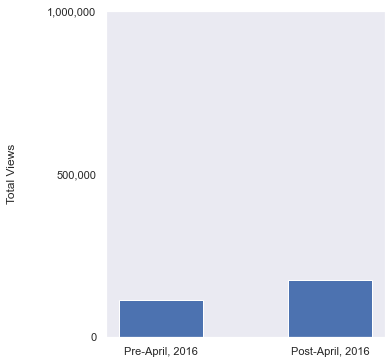

In [82]:
# Create an aggregated months DataFrame
aggregated_months = agg_monthly(df)

hist_mean(aggregated_months,'2016-04-27')

## C. ITS Regression

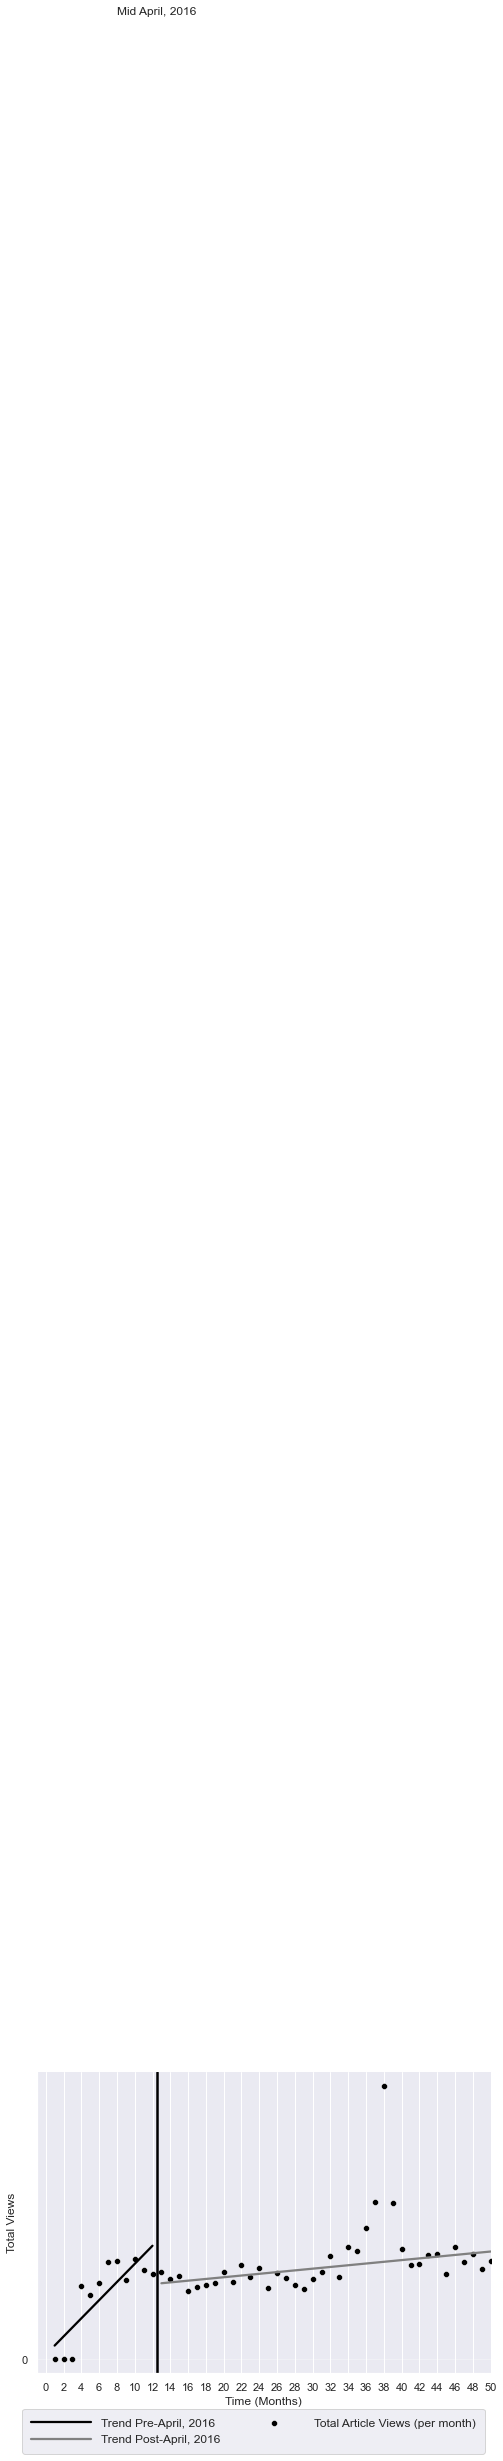

In [84]:
segmented_reg_1_set(aggregated_months, '2016-04-27', reference_point)

In [55]:
# Compute 95% confidence intervals for each monthly estimated average
y_error_treatment = bootstrap_CI(temp_treatment, 200)
y_error_control = bootstrap_CI(temp_control, 200)

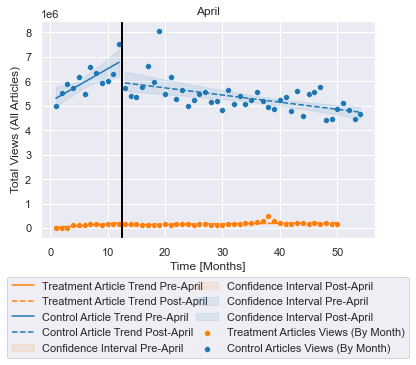

In [56]:
plotting('April', 'Treatment', 'Control', reference_point, temp_treatment, ypred_treatment, y_error_treatment, temp_control, ypred_control, y_error_control)

---
# GPDR Begginig of enforcement
The GDPR regulation was applied starting from the $25^{th}$ of May $2018$ for every country of the European Union (EU) and European Economic Area (EEA). We aim to answer the following questions regarding the event : 
* Is there an inverse chilling effect (e.g. immediate spike) following the day when the regulation became effective?
* Has there been a change in trends in the viewing of critical terms related to the regulation after the event?

We will thus answer these questions using the analysis methods from the reference paper and draw conclusions.

## A. Monthly Aggregation

In [86]:
# Reference point is the month of April 2016
reference_point = 37

In [87]:
# Compute trends predictions for treatment datasets
temp_treatment = monthly_views_formatting(g_treatment, reference_point)
temp_treatment.drop(temp_treatment.index[:3], inplace=True)
ypred_treatment = fit_model(formula='Pageviews ~ index + C(X) + XT', data=temp_treatment, predictor=temp_treatment, seed=2)

# Compute trends predictions for control datasets
temp_control = monthly_views_formatting(g_control, reference_point)
ypred_control = fit_model(formula='Pageviews ~ index + C(X) + XT', data=temp_control, predictor=temp_control, seed=2)

ypred_treatment.head()

3    131332.744538
4    132899.804584
5    134466.864629
6    136033.924675
7    137600.984721
dtype: float64

## B. Mean Computation

The formatted dataset correctly spans from 2015-04-30 to 2019-05-31.



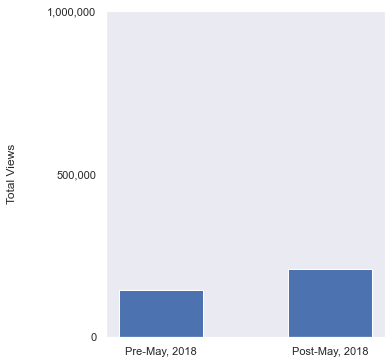

In [88]:
hist_mean(agg_monthly(df),'2018-05-25')

## C. ITS Regression

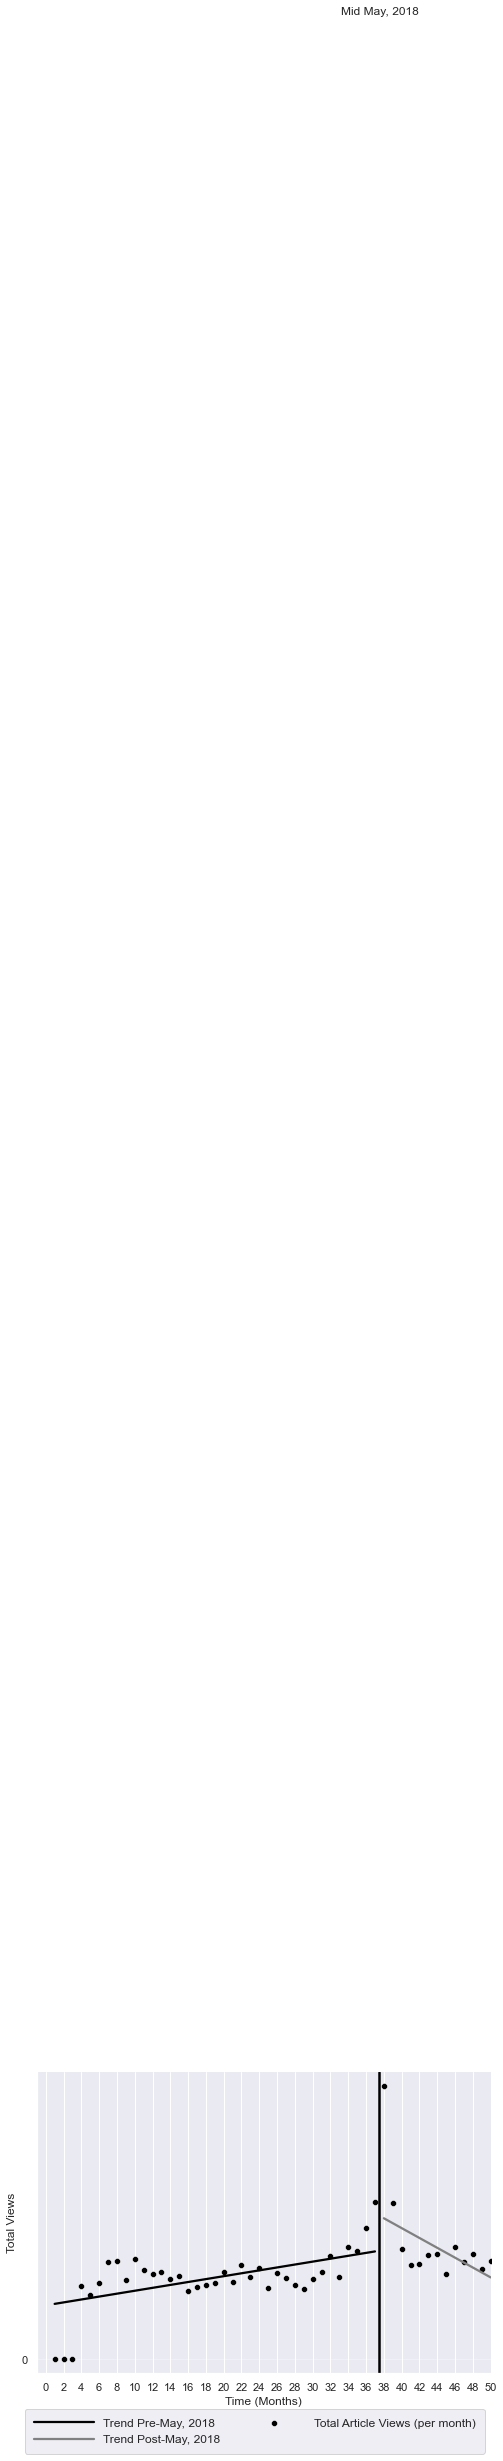

In [89]:
segmented_reg_1_set(aggregated_months, '2018-05-25', reference_point)

In [90]:
# Compute 95% confidence intervals for each monthly estimated average
y_error_treatment = bootstrap_CI(temp_treatment, 200)
y_error_control = bootstrap_CI(temp_control, 200)

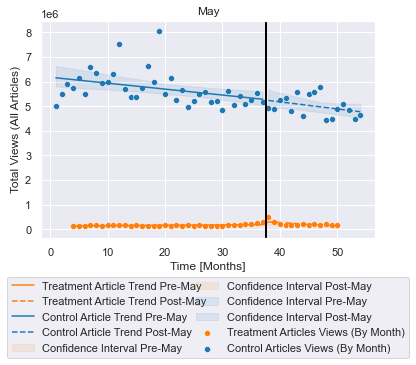

In [91]:
plotting('May', 'Treatment', 'Control', reference_point, temp_treatment, ypred_treatment, y_error_treatment, temp_control, ypred_control, y_error_control)

# Conclusion